# MongoDB数据库

# 1. 简介

① MongoDB是由C++语言编写的非关系型数据库，是一个基于分布式文件存储的数据库系统，其内容存储形式类似JSON对象，它的字段值可以包含其他文档、数组及文档数组，非常灵活。

② 在开始之前，要确保已经安装了MongoDB并启动了其服务，并且安装了Python的PyMongo库。

③ 连接MongoDB时，我们需要使用PyMongo库里面的MongoClient。一般来说，传入MongoDB的IP及端口即可，其中第一个参数为地址host，第二个参数为端口port（如果不给它传递参数，默认是27017）。

④ MySQL可以多个表进行关联，MongoDB是非关系型数据库，一般没有多个表进行关联。

# 2. 代码

## 2.1 插入单条数据

In [1]:
#coding=utf-8
import pymongo
client = pymongo.MongoClient(host='localhost',port=27017)
db = client.test 
collection = db.mongtest 
mongtest = {"id":100001,
            "name":"zhangsan",
           "age":22,
           "gender":"male",
           "a":111,
           "b":[1,1,2,3,4,5]}
result = collection.insert(mongtest) # 插入数据，参数为字典
print(result)

60cd758c8fa75434c7c3b682


<ipython-input-1-9fa5b35278f0>:12: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  result = collection.insert(mongtest) # 插入数据，参数为字典


## 2.2 插入多条数据

In [2]:
#coding=utf-8
import pymongo
client = pymongo.MongoClient(host='localhost',port=27017)
db = client.test         # 创建MongoDB的test数据库
collection = db.mongtest # 创建test数据库中的mongotest表
mongtest1 = {"id":100002,
            "name":"lisi",
           "age":25,
           "gender":"male",
           "a":333,
           "b":[1,2,3,4]}
mongtest2 = {"id":100003,
            "name":"wangwu",
           "age":26,
           "gender":"female",
           "a":444,
           "b":[2,3,4,5]}
result = collection.insert([mongtest1,mongtest2]) # mongtest表中插入两条数据
print(result)

[ObjectId('60cd759d8fa75434c7c3b684'), ObjectId('60cd759d8fa75434c7c3b685')]


<ipython-input-2-ee5c285dc260>:18: DeprecationWarning: insert is deprecated. Use insert_one or insert_many instead.
  result = collection.insert([mongtest1,mongtest2]) # mongtest表中插入两条数据


## 2.3 Scrapy连接MongoDB

### 2.3.1 items.py文件

In [ ]:
import scrapy 
class NewsItem(scrapy.Item):
    title = scrapy.Field()
    new_url = scrapy.Field()
    abstract = scrapy.Field()
    new_type = scrapy.Field()
    date = scrapy.Field()
    image_url = scrapy.Field()
    new_content = scrapy.Field()

### 2.3.2 touzijie.py文件

#### 2.3.2.1 解析new_url获得内容

In [ ]:
#coding=utf-8
import scrapy 
from news.items import NewsItem
import requests
from lxml import etree
import re
import os

class TouzijieSpider(scrapy.Spider):
    name = 'touzijie'
    allowed_domains = ['pe.pedaily.cn']
    
    # 方法2：字符串替换实现翻页
    start_urls = ['https://pe.pedaily.cn/vcpe/1/']
    page = 1  # 类属性 用self.page 调用

    dir_name = r'.\content'
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    def parse(self, response):
        news = response.xpath('//*[@id="newslist-all"]/li')
        for new in news:
            new_item = NewsItem()
            new_item['title'] = new.xpath('./div[2]/h3/a/text()').extract_first()     
            new_item['new_url'] = new.xpath('./div[2]/h3/a/@href').extract_first()                        
            new_item['abstract'] = new.xpath('./div[2]/div[1]/text()').extract_first()       
            new_types = new.xpath('./div[2]/div[2]/a')    
            new_item['new_type'] = ','.join([types.xpath('./text()').extract_first() for types in new_types])               
            new_item['date'] = new.xpath('./div[2]/div[2]/span/text()').extract_first()    
            new_item['image_url'] = new.xpath('./div[1]/a/img/@src').extract_first()  
            if new_item['new_url']:
                new_item["new_content"] = self.content(new_item['new_url'])    
            yield new_item
            
        print('当前的url：',response.url)
        next_url = response.url.replace(str(self.page),str(self.page+1))  #类属性要用self去调用           
        print('下一页url：',next_url)
        self.page += 1
        if self.page>100:
            pass
        else:
            yield scrapy.Request(url=next_url,callback=self.parse)
            
    def content(self,url):
        headers = {
            "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9",   
            "Accept-Encoding":"gzip, deflate, br",  
            "Accept-Language":"zh-CN,zh;q=0.9",   
            "User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.212 Safari/537.36"     
        }
        if url:
            res = requests.get(url,headers = headers)
            res.encoding = 'utf-8'
            html = etree.HTML(res.text)
            duanluos = html.xpath('//*[@id="news-content"]/p')
            if duanluos:
                content = '\n'.join([duanluo.xpath('./text()')[0] for duanluo in duanluos if duanluo.xpath('./text()')])     
        return content

#### 2.3.2.2 传递new_item添加内容

In [ ]:
#coding=utf-8
import scrapy 
from news.items import NewsItem
import requests
from lxml import etree
import re
import os

class TouzijieSpider(scrapy.Spider):
    name = 'touzijie'
    allowed_domains = ['pe.pedaily.cn']
    
    # 方法2：字符串替换实现翻页
    start_urls = ['https://pe.pedaily.cn/vcpe/1/']
    page = 1  # 类属性 用self.page 调用

    dir_name = r'.\content'
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    def parse(self, response):
        news = response.xpath('//*[@id="newslist-all"]/li')
        for new in news:
            list1 = [1,2,3,'q']
            new_item = NewsItem()
            new_item['title'] = new.xpath('./div[2]/h3/a/text()').extract_first()     
            new_item['new_url'] = new.xpath('./div[2]/h3/a/@href').extract_first()                        
            new_item['abstract'] = new.xpath('./div[2]/div[1]/text()').extract_first()       
            new_types = new.xpath('./div[2]/div[2]/a')    
            new_item['new_type'] = ','.join([types.xpath('./text()').extract_first() for types in new_types])               
            new_item['date'] = new.xpath('./div[2]/div[2]/span/text()').extract_first()    
            new_item['image_url'] = new.xpath('./div[1]/a/img/@src').extract_first()  
            if new_item['new_url']:
                # meta使得把new_item、alist传入到callback_content中，可以使用new_item、alist        
                yield scrapy.Request(url=new_item['new_url'],meta={"new_item":new_item,"alist":list1},callback=self.callback_content)     
            #yield new_item
            
        print('当前的url：',response.url)
        next_url = response.url.replace(str(self.page),str(self.page+1))  #类属性要用self去调用           
        print('下一页url：',next_url)
        self.page += 1
        if self.page>100:
            pass
        else:
            yield scrapy.Request(url=next_url,callback=self.parse)
    
    def callback_content(self,response):
        a = response.meta["alist"]
        a.append('aaaa')
        print(a)
        new_item = response.meta["new_item"]        
        duanluos = response.xpath('//*[@id="news-content"]/p')
        if duanluos:
            content = '\n'.join([duanluos.xpath('./text()').extract_first() for duanluo in duanluos if duanluo.xpath('./text()').extract_first()])
            response.meta["new_item"]["new_content"] = content
        yield response

### 2.3.3 setting.py 

In [ ]:
# 这是setting.py 文件(设置爬虫配准)

BOT_NAME = 'news'

SPIDER_MODULES = ['news.spiders']
NEWSPIDER_MODULE = 'news.spiders'

# Obey robots.txt rules
ROBOTSTXT_OBEY = False  # 为True表示遵守 ROBOST 协议，为False表示不遵守 ROBOST 协议
                        # ROBOST 协议即别人不允许你爬的，你爬的话会自动报错。

DEFAULT_REQUEST_HEADERS = {
"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36"
}
# 这里用的是豆瓣头文件覆盖的原内容

ITEM_PIPELINES = {
    'news.pipelines.NewsPipeline': 300, 
    'news.pipelines.MysqlPipeline': 301, 
    'news.pipelines.MongodbPipeline': 302
}

FEED_EXPORT_ENCODING = 'utf-8'

### 2.3.4 pipelines.py

In [ ]:
#coding=utf-8
from itemadapter import ItemAdapter
from news.mysql_operater import PythonMysql # mysql_operater.py 在news文件夹下
import csv 
import pymongo

class NewsPipeline:
    def __init__(self):
        self.filename = 'news.csv'
        
    def process_item(self,item,spider):    
        self.write_csv(item)
        return item
    
    def write_csv(self,dictdata):
        with open(self.filename,'a',encoding='utf-8-sig',newline='') as csvf:             
            fieldnames = ['title','new_url','abstract','new_type','date','image_url','new_content']        
            writer = csv.DictWriter(csvf,fieldnames=fieldnames)                                  
            writer.writerow(dictdata)   
        
class MysqlPipeline:
    def __init__(self):
        self.mysql = PythonMysql(host='localhost',user='root',password='password',port=3306)                  
        self.create_sql = '''
                          create table if not exists ai.news_data
                           (
                           title varchar(500) comment '新闻名',   
                           new_url varchar(100) comment '新闻链接',
                           abstract text comment '摘要',
                           new_type varchar(150) comment '新闻类型',
                           date varchar(100) comment '新闻发布日期',
                           image_url varchar(100) comment '图片链接'
                           )
                          '''
        self.mysql.create_table(self.create_sql) # 在初始化中创建表
        
    def process_item(self,item,spider):
        insert_sql = '''
                     insert into ai.news_data values('{}','{}','{}','{}','{}','{}')
                     '''                                 
        insert_sql = insert_sql.format(item['title'],
                                       item['new_url'],
                                       item['abstract'],
                                       item['new_type'],
                                       item['date'],
                                       item['image_url'])
        self.mysql.insert_mysql(insert_sql)
        return item   
    
class MongodbPipeline:
    def __init__(self):
        self.client = pymongo.MongoClient(host='localhost',port=27017)
        self.db = self.client.scrapy_data
        self.collection = self.db.news_data
        
    def process_item(self, item, spider):
        self.collection.insert(dict(item))
        return item 

### 2.3.5 mysql_operater.py

In [ ]:
#coding=utf-8
import pymysql
class PythonMysql(object):
    # 构造方法
    def __init__(self,host,user,password,port):
        self.host = host
        self.user = user
        self.password = password
        self.port = port
        self.mysql_db = self.connect_mysql()
    
    # 连接数据库
    def connect_mysql(self):
        try:
            mysql_db = pymysql.connect(host=self.host,
                                       user=self.user,
                                       password=self.password,
                                       port=self.port)
            print('数据库连接成功')
            return mysql_db
        except Exception as e:
            print(e)
            print('数据库连接失败')
            return None
        
    # 创建表
    def create_table(self,create_table_sql):
        try:
            cursor =  self.mysql_db.cursor()
            cursor.execute(create_table_sql)
            print('创建表成功')
        except Exception as e:
            print(e)
            print('创建表失败')
            
    # 查询数据
    def select_mysql(self,qurey_sql):
        cursor =  self.mysql_db.cursor()
        cursor.execute(qurey_sql)
        return self.mysql_db.cursor.fetchall()
    
    # 插入数据
    def insert_mysql(self,insert_sql):
        try:
            cursor =  self.mysql_db.cursor()
            cursor.execute(insert_sql)  # 执行插入语句
            self.mysql_db.commit() # commit方法跟在增删改查后面，意味着把语句提交给数据库
        except Exception as e:
            print(e)
            print(insert_sql)
            self.mysql_db.rollback()

### 2.3.6 main.py

① 如果不导入CMDLINE模块，那么只能通过ananconda prompt中输入scrapy crawl touzijie启动爬虫。

② 但是导入scrapy.cmdline 中的 execute 后，可以通过设置断点来调试 items.py、touzijie.py、setting.py、pipelines.py 文件。

③ main.py 文件是与scrapy.cfg 以及 news 文件夹同级的文件。

In [ ]:
# main.py 文件 (代替cmd命令行输入语句来运行，方便调试)

from scrapy.cmdline import execute 

execute(["scrapy","crawl","touzijie"])

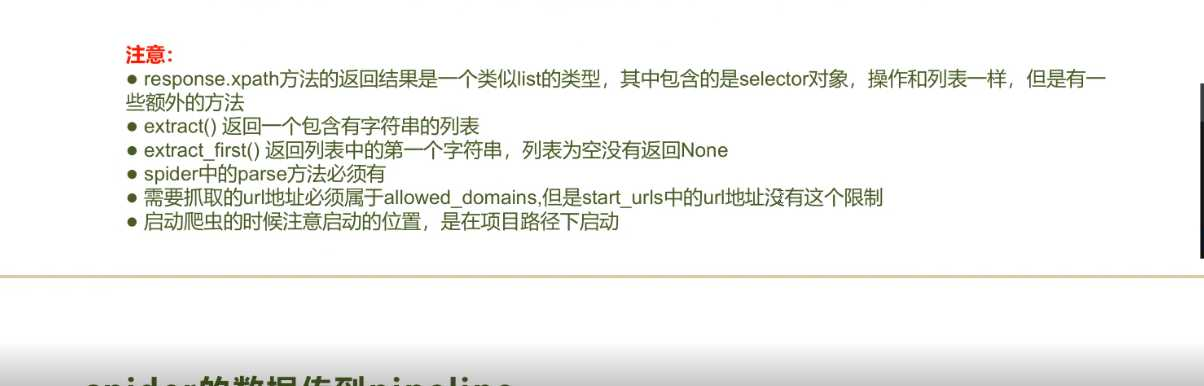